# Modelling template - ShoreShop 2.0
A template to load the data for easy modelling (data can be explored in `1.data_explore.ipynb`).

In [1]:
# magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from functions.data_load import load_modelling_data, tabularise_raw_data

## Load the data

Load the data using `load_modelling_data()` that returns a dictionary containing the following pandas DataFrames mirroring `1.data_explore.ipynb` (with indices as datetime objects where possible):

- `df_tran`: Transect data.
- `df_gt`: Groundtruth shoreline positions.
- `df_targ_short`: Short-term target shoreline positions.
- `df_targ_medium`: Medium-term target shoreline positions.
- `df_obs`: Observed shoreline positions.
- `dfs_wave`: Wave data for different parameters ('Hs', 'Tp', 'Dir').
- `df_SLR_obs`: Observed sea level rise data.
- `df_SLR_proj`: Projected sea level rise data.

Provided information:
A sequence of shore-normal transects were defined from North to South.\
The distance between transects is 100 m alongshore\
The coordinates of transects were intentionally shifted.

Shoreline positions were retrieved from Landsat 5, 7, 8 and 9 satellite images with [CoastSat toolbox](https://github.com/kvos/CoastSat/tree/master).\
All the shorelines have been corrected to reflect the instaneous position at Mean Sea Level\
Only shorelines from 1987 to 2018 are avaiable for model training/calibration in this site.\
Along each transect, shoreline positions were provided as the distance to the **landward** end of the transect.

Offshore wave data is from [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) wave spectra data.\
SWAN model was used to transfer offshore wave into nearshore with [Binwave](https://www.sciencedirect.com/science/article/pii/S1463500324000337) approach developed by Dr Laura Cagigal.\
Along each transect, the wave data was extracted at 10m contour 

In [3]:
basedir = '.' # where are you in relation to the root directory
raw_data = load_modelling_data(basedir=basedir)

df_tran: Loaded 9 transects...
df_gt: Loaded (3, 9) (dates,transects) groundtruth shoreline positions...1999-06-20 to 2018-08-17
df_targ_short: Loaded (119, 9) (dates,transects) short-term target shoreline positions...2019-01-14 to 2023-12-27
df_targ_medium: Loaded (116, 9) (dates,transects) medium-term target shoreline positions...1951-05-01 to 1998-10-27
df_obs: Loaded (347, 9) (dates,transects) observed shoreline positions...1999-02-16 to 2018-12-29
dfs_wave["Hs"]: Loaded (30678, 9) (dates,transects) Hs wave data...
dfs_wave["Tp"]: Loaded (30678, 9) (dates,transects) Tp wave data...
dfs_wave["Dir"]: Loaded (30678, 9) (dates,transects) Dir wave data...
Wave data spans: 1940-01-02 to 2023-12-29 at 1 day(s) interval
df_SLR_obs: Loaded (38, 1) (years, ['SLR (mm)']) observed sea level rise data...1981 to 2018
df_SLR_proj: Loaded (82, 2) (years, ['RCP45', 'RCP85']) projected sea level rise data...2019 to 2100


## Optional preprocessing
Here is provided a template for optional preprocessing steps that can be used to tabularise the data for modelling. Adopted the frequency of the wave data, but this can of course be adjusted.

In [5]:
# Optional pre-processing
tabular_data = tabularise_raw_data(raw_data)

### Quick visualisation
Some quick visualisation of the data to show the format

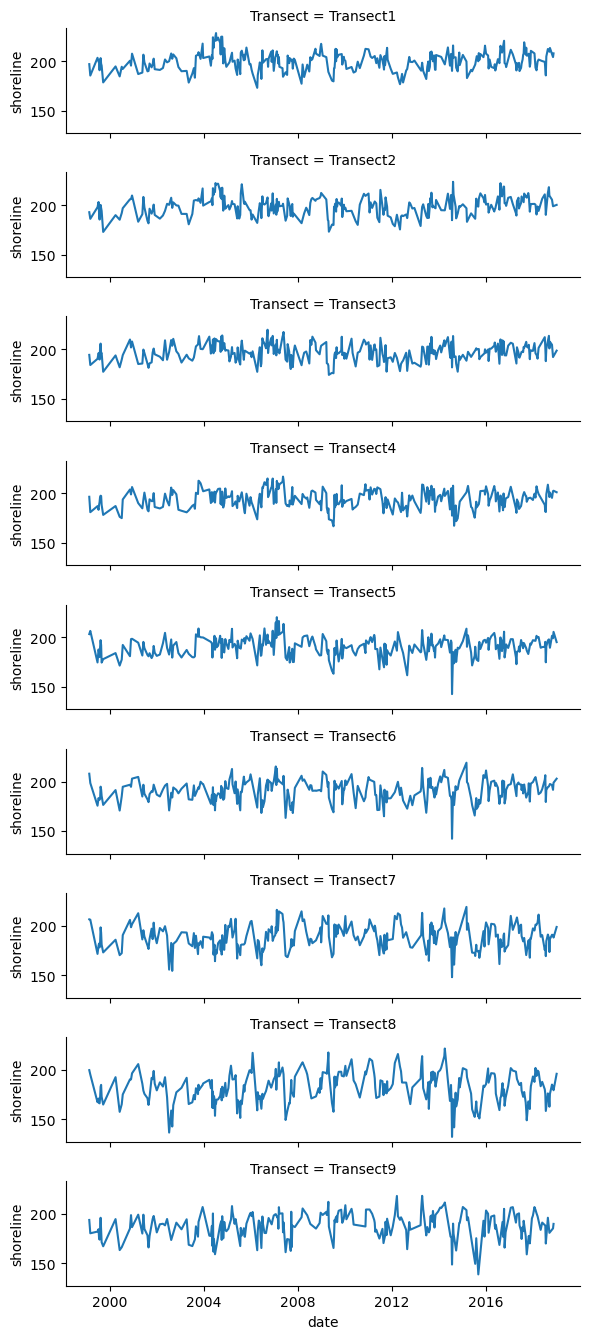

In [19]:
# vis of transect data
sns.FacetGrid(data=tabular_data['df_obs'],row='Transect', aspect=4, height=1.5).map_dataframe(sns.lineplot,y='shoreline',x='date')
plt.show()

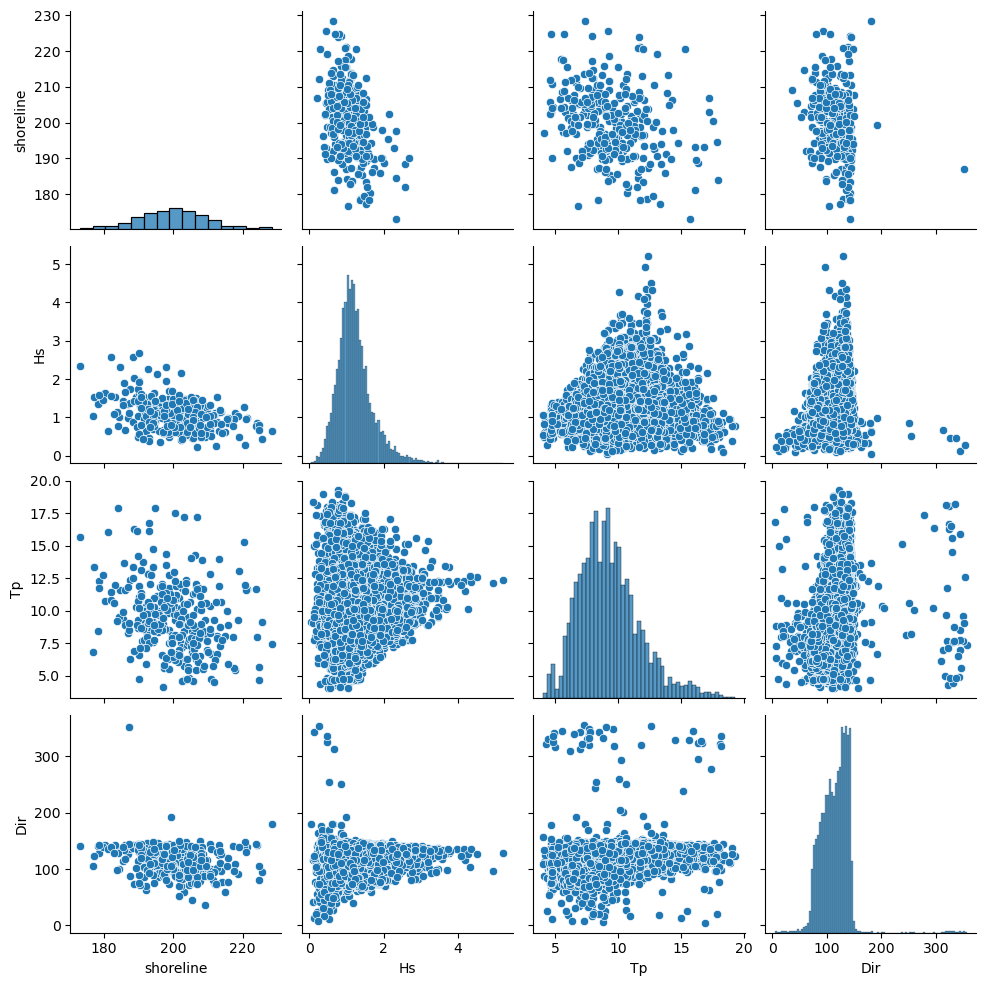

In [18]:
# pairplot the data
trans_id = 'Transect1'
sns.pairplot(
    tabular_data['df_obs'].query('Transect == @trans_id').drop(columns=['Transect','date'])
)
plt.show()

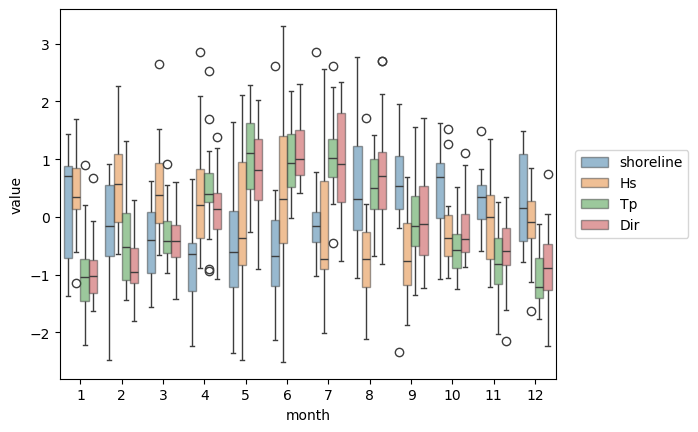

In [23]:
# plot the seasonal averages
trans_id = 'Transect1'
plot_data = tabular_data['df_obs'].query('Transect == @trans_id').drop(columns=['Transect']).set_index('date').resample('1ME').mean()
plot_data = plot_data.assign(month=plot_data.index.month)
# demean and stanardise the variables
for _ in [_ for _ in plot_data.columns if not _ in ['month']]:
    plot_data[_] = (plot_data[_] - plot_data[_].mean())/plot_data[_].std()
sns.boxplot(data=plot_data.melt(id_vars='month'),x='month',y='value',hue='variable',boxprops=dict(alpha=.5))
plt.legend(loc=6,bbox_to_anchor=(1.025,0.5))
plt.show()

## Modelling attempt
Here you can construct your model and make some predictions.